Empirical data fitting results:
MT = 91.97 + 290.31 ID
R_squared = 0.83


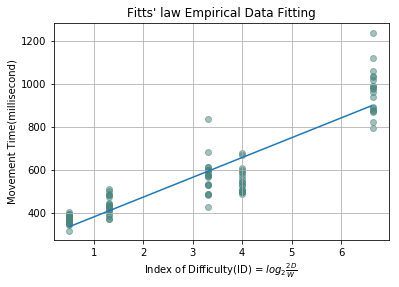

In [56]:
# ============================================================================
# Author  : Jiayao Yu, User Interfaces Group, Aalto University
# Init    : August, 2017
# Project : ELEC-D7010 Engineering for Humans course materials
# Topic   : Fitts' Law
# ============================================================================

# ============================================================================
# 2 Fitts' Law
# ---------------------------------------
# GUI Usage:
#   1) Sliders: to change the width of / distance between two objects
#   2) ID: real-time calcularion of Index of Difficulty according to width and distance
#   3) Count down times: to indicate how many times left for finishing this round of pointings
#   4) To get polynominal data fitting, you need to try at least 3 ID settings
# 	5) You may "preload" our dataset to sneak peek, then "clear data" to perform your own experiment
# Preassumption:
#   1) Moving locus is 1D horizontal straight line
#   2) Start timing after tapping on either one of the two buttons
# ============================================================================

import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
import time as tm
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import string

class Fitts(tk.Frame):
	areaWidth = 700
	width = 40
	distance = 250
	areaCornerWidth = (areaWidth - width*2 - distance)/2
	mtList = []	# list of Movement Time
	idList = []	# list of Index of Difficulty
	z = []		# list of polynominal coefficients from empirical data fitting
	counterId = 0	# count the amount of ID settings, for data fitting
	idValue = 4.0

	def __init__(self, parent=None):
		tk.Frame.__init__(self, parent)
		self.pack()
		self.makeWidgets()

	def makeWidgets(self):
		self.frameIdController = tk.Frame(self, width=self.areaWidth, height=100)
		self.framePointingArea = tk.Frame(self, width=self.areaWidth, height=250, borderwidth=2, relief=tk.GROOVE)
		self.frameTimer = ttk.Labelframe(self, text='Delta Time')

		self.frameIdController.grid(row=0, column=0, padx=10, pady=10, ipadx=10, ipady=10, sticky=tk.EW)
		self.framePointingArea.grid(row=1, column=0, padx=10, pady=10, ipadx=10, ipady=10)
		self.framePointingArea.grid_propagate(0)

		# width, distance controller
		self.varWidth = tk.DoubleVar()
		self.varWidth.set(self.width)
		self.varDistance = tk.DoubleVar()
		self.varDistance.set(self.distance)
		self.scaleWidth = tk.Scale(self.frameIdController, from_=10, to=70, variable=self.varWidth, command=self.onScaleChanged, orient=tk.HORIZONTAL)
		self.scaleDistance = tk.Scale(self.frameIdController, from_=50, to=500, variable=self.varDistance, command=self.onScaleChanged, orient=tk.HORIZONTAL)
		vcmd = (self.frameIdController.register(self.validate), '%d', '%S')
		self.varCounter = tk.StringVar()
		self.varCounter.set("10")
		self.entryCounter = tk.Entry(self.frameIdController, textvariable=self.varCounter, validate="key", validatecommand=vcmd)
		self.countDown = tk.IntVar()
		self.labelCountDown = tk.Label(self.frameIdController, textvariable=self.countDown, bg="white", fg="black", font=("Arial", 20), width=9)
		self.labelCountDownText = tk.Label(self.frameIdController, text="Remaining clicking(s):")
		self.labelWidth = tk.Label(self.frameIdController, text="Width (pixel)")
		self.labelDistance = tk.Label(self.frameIdController, text="Distance (pixel)")
		self.labelId = tk.Label(self.frameIdController, text="ID = %0.2f" %self.idValue, bg='#9ED2CC', width=10, font=("Arial", 20))
		self.labelCounter = tk.Label(self.frameIdController, text="Counter =")
		self.labelCounterSuggestion = tk.Label(self.frameIdController, text="(Suggested counter: 10 - 20)")
		
		self.buttonPreload = tk.Button(self.frameIdController, text="Preload Dataset", width=10, padx=10, pady=5)
		self.buttonStart = tk.Button(self.frameIdController, text="Start", width=10, padx=10, pady=10)
		self.buttonStop = tk.Button(self.frameIdController, text="Stop", width=10, padx=10, pady=10)
		self.buttonClearData = tk.Button(self.frameIdController, text="Clear Data", width=20, padx=10, pady=10)

		self.buttonPreload.grid(row=0, column=0, padx=10, pady=3, ipadx=10, sticky=tk.NSEW)
		self.buttonStart.grid(row=1, column=0, padx=10, pady=3, rowspan=3, ipadx=10, sticky=tk.NSEW)
		self.labelWidth.grid(row=0, column=1, sticky=tk.W+tk.S)
		self.scaleWidth.grid(row=0, column=2, sticky=tk.EW+tk.S)
		self.labelDistance.grid(row=1, column=1, sticky=tk.W+tk.S)
		self.scaleDistance.grid(row=1, column=2, sticky=tk.EW+tk.N)
		self.labelCounter.grid(row=2, column=1, pady=20, sticky=tk.W+tk.S)
		self.entryCounter.grid(row=2, column=2, pady=20, sticky=tk.EW+tk.S)
		self.labelCounterSuggestion.grid(row=3, column=2, sticky=tk.NE)
		self.labelId.grid(row=0, column=3, rowspan=4, padx=10, pady=10, sticky=tk.NSEW)
		self.labelId.grid_propagate(0)
		self.buttonClearData.grid(row=0, column=4, padx=10, pady=10, sticky=tk.NSEW)

		# Pointing area
		self.frameNWCorner = tk.Frame(self.framePointingArea, width=self.areaCornerWidth, height=100)
		self.frameSWCorner = tk.Frame(self.framePointingArea, width=self.areaCornerWidth, height=100)
		self.frameNECorner = tk.Frame(self.framePointingArea, width=self.areaCornerWidth, height=100)
		self.frameSECorner = tk.Frame(self.framePointingArea, width=self.areaCornerWidth, height=100)
		self.frameDistance = tk.Frame(self.framePointingArea, width=self.distance, height=50)
		self.frameObj1 = tk.Frame(self.framePointingArea, width=self.width, height=50)
		self.frameObj2 = tk.Frame(self.framePointingArea, width=self.width, height=50)
		self.obj1=tk.Button(self.frameObj1, state=tk.DISABLED, activebackground='#4A857E')
		self.obj2=tk.Button(self.frameObj2, state=tk.DISABLED, activebackground='#4A857E')
		self.frameNWCorner.grid(row=0, column=0)
		self.frameNECorner.grid(row=0, column=4)
		self.frameObj1.grid(row=1, column=1)
		self.frameObj1.rowconfigure(0, weight=1)
		self.frameObj1.columnconfigure(0, weight=1)
		self.frameObj1.grid_propagate(0)
		self.obj1.grid(sticky=tk.NSEW)
		self.frameDistance.grid(row=1, column=2)
		self.frameDistance.grid_propagate(0)
		self.frameObj2.grid(row=1, column=3)
		self.frameObj2.rowconfigure(0, weight=1)
		self.frameObj2.columnconfigure(0, weight=1)
		self.frameObj2.grid_propagate(0)
		self.obj2.grid(sticky=tk.NSEW)
		self.frameSWCorner.grid(row=2, column=0)
		self.frameSECorner.grid(row=2, column=4)

		self.buttonPreload.bind("<ButtonRelease-1>", self.preloadData)
		self.buttonStart.bind("<ButtonRelease-1>", self.onStartClicked)
		self.buttonStop.bind("<ButtonRelease-1>", self.onStopClicked)
		self.buttonClearData.bind("<ButtonRelease-1>", self.onClearDataClicked)

	def onScaleChanged(self, event):
		width = int(self.varWidth.get())
		self.frameObj1.config(width=width)
		self.frameObj2.config(width=width)
		distance = self.varDistance.get()
		areaCornerWidth = (self.areaWidth - width*2 - distance)/2
		self.frameDistance.config(width=distance)
		self.frameNWCorner.config(width=areaCornerWidth)
		self.frameSWCorner.config(width=areaCornerWidth)
		self.frameNECorner.config(width=areaCornerWidth)
		self.frameSECorner.config(width=areaCornerWidth)
		self.idValue = np.log2(2 * distance / width)
		self.labelId.config(text="ID = %0.2f" %self.idValue)

# validate if counter entry is only digit
	def validate(self, d, S):
	    if S in string.digits:
	        return True
	    else:
	        return False

	def preloadData(self, event):
		self.idList = [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 
						1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 1.32, 
						0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 0.51, 
						3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 3.32, 
						6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64, 6.64]
		self.mtList = [598.52, 574.75, 671.49, 496.53, 556.67, 588.21, 592.83, 491.16, 528.81, 529.30, 677.92, 543.81, 506.00, 608.82, 542.59, 499.40, 500.52, 513.11, 498.15, 484.24, 
						512.48, 501.46, 488.67, 483.22, 442.83, 444.87, 427.46, 476.46, 434.70, 413.72, 427.83, 419.46, 397.71, 374.59, 387.40, 375.00, 409.95, 438.40, 405.28, 381.12, 
						389.36, 365.78, 381.68, 395.48, 359.66, 373.50, 397.46, 363.98, 382.05, 343.17, 381.53, 348.88, 358.21, 352.18, 357.31, 319.05, 373.98, 482.85, 429.81, 599.11, 
						835.66, 566.60, 531.21, 575.82, 614.65, 586.40, 571.92, 602.28, 536.38, 491.15, 685.49, 598.81, 489.13, 530.33, 576.10, 615.46, 796.41, 893.84, 880.68, 1058.90, 
						870.79, 1120.74, 1016.88, 974.99, 1236.62, 979.50, 991.01, 873.18, 822.72, 936.90, 963.19, 1035.85, 887.92, 1033.97, 991.20]
		# self.counterId == 5
		# self.plots()
		# polynomial data fitting
		fig = plt.figure()
		graph = fig.add_subplot(111)
		graph.set(title="Fitts' law Empirical Data Fitting", ylabel="Movement Time(millisecond)", 
					xlabel="Index of Difficulty(ID) = $log_2 \\frac{2D}{W}$")
		graph.scatter(self.idList, self.mtList, color="#4A857E", alpha=0.5)

		self.z = np.polyfit(self.idList, self.mtList, 1)
		f = np.poly1d(self.z)
		idArray = np.array(self.idList)
		x = np.arange(idArray.min(), idArray.max(), 0.1)
		y = f(x)
		plt.plot(x, y)
		# compute r-squared
		mtHat = f(self.idList)
		mtBar = np.sum(self.mtList)/len(self.mtList)
		ssreg = np.sum((mtHat - mtBar)**2)
		sstot = np.sum((self.mtList - mtBar)**2)
		self.determination = ssreg / sstot
		plt.grid()
		print ("Empirical data fitting results:\nMT = %0.2f + %0.2f ID\nR_squared = %0.2f" %(self.z[0], self.z[1], self.determination))
		plt.show()

	def onStartClicked(self, event):
		if not self.entryCounter.get():
			tk.messagebox.showinfo("Reminder", "Please input a counter!")
		else:
			# self.timestampTemp = tm.clock()
			self.buttonStart.grid_forget()
			self.buttonPreload.grid_forget()
			self.buttonStop.grid(row=1, column=0, padx=10, pady=10, rowspan=3, ipadx=10, sticky=tk.NSEW)			
			self.counter = 0
			self.counterMax = int(self.entryCounter.get())
			self.countDown.set(self.counterMax)
			self.labelCountDownText.grid(row=1, column=4, padx=10, sticky=tk.SW)
			self.labelCountDown.grid(row=2, column=4, padx=10, sticky=tk.NSEW)
			self.scaleWidth.config(state=tk.DISABLED)
			self.scaleDistance.config(state=tk.DISABLED)
			self.entryCounter.config(state=tk.DISABLED)
			self.obj1.config(bg='#9ED2CC', state=tk.NORMAL)
			self.obj2.config(bg='#9ED2CC', state=tk.NORMAL)
			self.obj1.bind("<ButtonRelease-1>", self.cursorMovement)
			self.obj1.bind("<Button-1>", self.onCounter)
			self.obj2.bind("<ButtonRelease-1>", self.cursorMovement)
			self.obj2.bind("<Button-1>", self.onCounter)

	def cursorMovement(self, event):
		if self.counter == 1:
			self.timestampTemp = tm.clock()
		elif self.counter >= 1 and self.counter <= self.counterMax:
			# avoid clicking on the same object twice
			if event.widget == self.obj1:
				self.obj1.config(state=tk.DISABLED, bg="SystemButtonFace")
				self.obj1.unbind("<ButtonRelease-1")
				self.obj1.unbind("<Button-1>")
				self.obj2.config(state=tk.NORMAL, bg="#9ED2CC")
				self.obj2.bind("<ButtonRelease-1>", self.cursorMovement)
				self.obj2.bind("<Button-1>", self.onCounter)
			if event.widget == self.obj2:
				self.obj1.config(state=tk.NORMAL, bg='#9ED2CC')
				self.obj1.bind("<ButtonRelease-1>", self.cursorMovement)
				self.obj1.bind("<Button-1>", self.onCounter)
				self.obj2.config(state=tk.DISABLED, bg="SystemButtonFace")
				self.obj2.unbind("<ButtonRelease-1>")
				self.obj2.unbind("<Button-1>")
			if self.counter > 1:
				# timing cursor one-way movement in millisecond
				timestamp = tm.clock()
				timeDelta = (timestamp - self.timestampTemp) * 1000
				self.timestampTemp = timestamp
				self.mtList.append(timeDelta)
				tk.Label(self.frameTimer, text="time = %0.2f ms" %self.mtList[-1], anchor = tk.W).grid(row = 1 + self.counter, column=0, sticky=tk.N)
				self.idList.append(self.idValue)
				self.plots()

		if self.counter == self.counterMax:
			self.counterId += 1
		elif self.counter > self.counterMax:
			self.obj1.config(state=tk.DISABLED, bg="SystemButtonFace")
			self.obj2.config(state=tk.DISABLED, bg="SystemButtonFace")
			self.scaleWidth.config(state=tk.NORMAL)
			self.scaleDistance.config(state=tk.NORMAL)
			self.buttonStop.grid_forget()
			self.buttonPreload.grid(row=0, column=0, padx=10, pady=3, ipadx=10, sticky=tk.NSEW)
			self.buttonStart.grid(row=1, column=0, padx=10, pady=10, rowspan=3, ipadx=10, sticky=tk.NSEW)

	def plots(self):
		# plot movement time against index of difficulty in real-time
		fig = plt.figure()
		graph = fig.add_subplot(111)
		graph.set(title="Fitts' law Empirical Data Fitting", ylabel="Movement Time(millisecond)", 
					xlabel="Index of Difficulty(ID) = $log_2 \\frac{2D}{W}$")
		graph.scatter(self.idList, self.mtList, color="#4A857E", alpha=0.5)

		if self.counterId > 1:
			print("go fitting")
			# polynomial data fitting
			self.z = np.polyfit(self.idList, self.mtList, 1)
			f = np.poly1d(self.z)
			idArray = np.array(self.idList)
			x = np.arange(idArray.min(), idArray.max(), 0.1)
			y = f(x)
			plt.plot(x, y)
			# compute r-squared
			mtHat = f(self.idList)
			mtBar = np.sum(self.mtList)/len(self.mtList)
			ssreg = np.sum((mtHat - mtBar)**2)
			sstot = np.sum((self.mtList - mtBar)**2)
			self.determination = ssreg / sstot
		display.clear_output(wait=True)
		plt.grid()
		if len(self.z) == 2:
			print ("Empirical data fitting results:\nMT = %0.2f + %0.2f ID\nR_squared = %0.2f" %(self.z[0], self.z[1], self.determination))
			print ("idList:\n"+str(self.idList)+"mtList:\n"+str(self.mtList))
		plt.show()


	def onCounter(self, event):
		if self.counter <= self.counterMax:
			self.counter += 1
			self.countDown.set(self.counterMax - self.counter + 1)

	def onStopClicked(self, event):
		self.buttonStart.grid(row=1, column=0, padx=10, pady=10, rowspan=3, ipadx=10, sticky=tk.NSEW)
		self.buttonStop.grid_forget()
		self.counter = 0
		self.scaleWidth.config(state=tk.NORMAL)
		self.scaleDistance.config(state=tk.NORMAL)
		self.entryCounter.config(state=tk.NORMAL)
		self.labelCountDownText.grid_forget()
		self.labelCountDown.grid_forget()

	def onClearDataClicked(self, event):
		self.idList = []
		self.mtList = []
		display.clear_output(wait=True)
		print("Cleared data, try again!")


if __name__ == "__main__":
	root = tk.Tk()
	root.title("Fitts' Law GUI")
	# root.geometry("1000x800")
	# root.resizable(width=False, height=False)
	Fitts(root).mainloop()